In [1]:
import jax 
from jaxmarl import make
from jaxmarl.viz.overcooked_visualizer import OvercookedVisualizer
from jaxmarl.environments.overcooked import Overcooked, overcooked_layouts, layout_grid_to_dict
import time

In [2]:
# Parameters + random keys
max_steps = 100
key = jax.random.PRNGKey(0)
key, key_r, key_a = jax.random.split(key, 3)

# Get one of the classic layouts (cramped_room, asymm_advantages, coord_ring, forced_coord, counter_circuit)
layout = overcooked_layouts["cramped_room"]

# Or make your own! (P=pot, O=onion, A=agent, B=plates?, X=deliver?)
#custom_layout_grid = """
#WWPWW
#WA AW
#B   X
#W   W
#WOWOW
#"""
#layout = layout_grid_to_dict(custom_layout_grid)

In [3]:
# Instantiate environment
env = make('overcooked', layout=layout, max_steps=max_steps)
obs, state = env.reset(key_r)
print('list of agents in environment', env.agents)

list of agents in environment ['agent_0', 'agent_1']


In [4]:
# Sample random actions
key_a = jax.random.split(key_a, env.num_agents)
actions = {agent: env.action_space(agent).sample(key_a[i]) for i, agent in enumerate(env.agents)}
print('example action dict', actions)

example action dict {'agent_0': Array(1, dtype=uint32), 'agent_1': Array(0, dtype=uint32)}


In [5]:
state_seq = []
for _ in range(max_steps):
    state_seq.append(state)
    # Iterate random keys and sample actions
    key, key_s, key_a = jax.random.split(key, 3)
    key_a = jax.random.split(key_a, env.num_agents)

    actions = {agent: env.action_space(agent).sample(key_a[i]) for i, agent in enumerate(env.agents)}

    # Step environment
    obs, state, rewards, dones, infos = env.step(key_s, state, actions)

In [6]:
viz = OvercookedVisualizer()

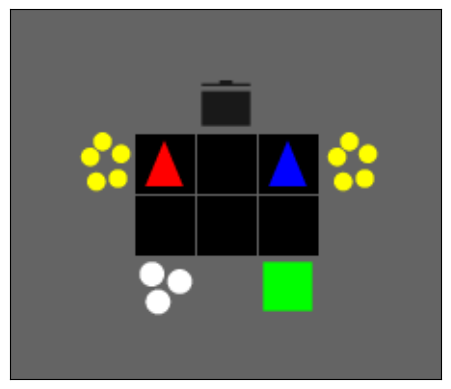

In [7]:
# Render to screen
for s in state_seq:
    viz.render(env.agent_view_size, s, highlight=False)
    time.sleep(0.25)

In [ ]:
def make_train(config):
    env = jaxmarl.make(config["ENV_NAME"], **config["ENV_KWARGS"])

    config["NUM_ACTORS"] = env.num_agents * config["NUM_ENVS"]
    print(f'NUM_ACTORS: {config["NUM_ACTORS"]}')
    config["NUM_UPDATES"] = (
        config["TOTAL_TIMESTEPS"] // config["NUM_STEPS"] // config["NUM_ENVS"]
    )
    print(f'NUM_UPDATES: {config["NUM_UPDATES"]}')
    config["MINIBATCH_SIZE"] = (
        config["NUM_ACTORS"] * config["NUM_STEPS"] // config["NUM_MINIBATCHES"]
    )
    print(f'NUM_MINIBATCHES: {config["NUM_MINIBATCHES"]}')
    print(f'MINIBATCH_SIZE: {config["MINIBATCH_SIZE"]}')

    env = LogWrapper(env)

    def linear_schedule(count):
        frac = 1.0 - (count // (config["NUM_MINIBATCHES"] * config["UPDATE_EPOCHS"])) / config["NUM_UPDATES"]
        return config["LR"] * frac

    def train(rng):

        # INIT NETWORK
        network = ActorCritic(env.action_space().n, activation=config["ACTIVATION"])
        rng, _rng = jax.random.split(rng)
        init_x = jnp.zeros(env.observation_space().shape)

        init_x = init_x.flatten()

        network_params = network.init(_rng, init_x)
        if config["ANNEAL_LR"]:
            tx = optax.chain(
                optax.clip_by_global_norm(config["MAX_GRAD_NORM"]),
                optax.adam(learning_rate=linear_schedule, eps=1e-5),
            )
        else:
            tx = optax.chain(optax.clip_by_global_norm(config["MAX_GRAD_NORM"]), optax.adam(config["LR"], eps=1e-5))
        train_state = TrainState.create(
            apply_fn=network.apply,
            params=network_params,
            tx=tx,
        )

        # INIT ENV
        rng, _rng = jax.random.split(rng)
        reset_rng = jax.random.split(_rng, config["NUM_ENVS"])
        obsv, env_state = jax.vmap(env.reset, in_axes=(0,))(reset_rng)
        print(obsv)
        print(env_state)

        # TRAIN LOOP
        def _update_step(runner_state, unused):
            # COLLECT TRAJECTORIES
            def _env_step(runner_state, unused):
                train_state, env_state, last_obs, rng = runner_state

                # SELECT ACTION
                rng, _rng = jax.random.split(rng)

                obs_batch = batchify(last_obs, env.agents, config["NUM_ACTORS"])

                pi, value = network.apply(train_state.params, obs_batch)
                action = pi.sample(seed=_rng)
                log_prob = pi.log_prob(action)
                env_act = unbatchify(action, env.agents, config["NUM_ENVS"], env.num_agents)

                env_act = {k:v.flatten() for k,v in env_act.items()}

                # STEP ENV
                rng, _rng = jax.random.split(rng)
                rng_step = jax.random.split(_rng, config["NUM_ENVS"])

                obsv, env_state, reward, done, info = jax.vmap(env.step, in_axes=(0,0,0))(
                    rng_step, env_state, env_act
                )
                
                ### MODIFICATIONS: I have changed the following line for the reshape_info one to avoid the TypeError: cannot reshape array of shape (16,) (size 16) into shape 32 (size 32)
                # info = jax.tree.map(lambda x: x.reshape((config["NUM_ACTORS"])), info)
            
                info = reshape_info(info)

                transition = Transition(
                    batchify(done, env.agents, config["NUM_ACTORS"]).squeeze(),
                    action,
                    value,
                    batchify(reward, env.agents, config["NUM_ACTORS"]).squeeze(),
                    log_prob,
                    obs_batch,
                    info

                )
                runner_state = (train_state, env_state, obsv, rng)
                return runner_state, transition

            runner_state, traj_batch = jax.lax.scan(
                _env_step, runner_state, None, config["NUM_STEPS"]
            )

            # CALCULATE ADVANTAGE
            train_state, env_state, last_obs, rng = runner_state
            last_obs_batch = batchify(last_obs, env.agents, config["NUM_ACTORS"])
            _, last_val = network.apply(train_state.params, last_obs_batch)

            def _calculate_gae(traj_batch, last_val):
                def _get_advantages(gae_and_next_value, transition):
                    gae, next_value = gae_and_next_value
                    done, value, reward = (
                        transition.done,
                        transition.value,
                        transition.reward,
                    )
                    delta = reward + config["GAMMA"] * next_value * (1 - done) - value
                    gae = (
                        delta
                        + config["GAMMA"] * config["GAE_LAMBDA"] * (1 - done) * gae
                    )
                    return (gae, value), gae

                _, advantages = jax.lax.scan(
                    _get_advantages,
                    (jnp.zeros_like(last_val), last_val),
                    traj_batch,
                    reverse=True,
                    unroll=16,
                )
                return advantages, advantages + traj_batch.value

            advantages, targets = _calculate_gae(traj_batch, last_val)

            # UPDATE NETWORK
            def _update_epoch(update_state, unused):
                def _update_minbatch(train_state, batch_info):
                    traj_batch, advantages, targets = batch_info

                    def _loss_fn(params, traj_batch, gae, targets):
                        # RERUN NETWORK
                        pi, value = network.apply(params, traj_batch.obs)
                        log_prob = pi.log_prob(traj_batch.action)

                        # CALCULATE VALUE LOSS
                        value_pred_clipped = traj_batch.value + (
                            value - traj_batch.value
                        ).clip(-config["CLIP_EPS"], config["CLIP_EPS"])
                        value_losses = jnp.square(value - targets)
                        value_losses_clipped = jnp.square(value_pred_clipped - targets)
                        value_loss = (
                            0.5 * jnp.maximum(value_losses, value_losses_clipped).mean()
                        )

                        # CALCULATE ACTOR LOSS
                        ratio = jnp.exp(log_prob - traj_batch.log_prob)
                        gae = (gae - gae.mean()) / (gae.std() + 1e-8)
                        loss_actor1 = ratio * gae
                        loss_actor2 = (
                            jnp.clip(
                                ratio,
                                1.0 - config["CLIP_EPS"],
                                1.0 + config["CLIP_EPS"],
                            )
                            * gae
                        )
                        loss_actor = -jnp.minimum(loss_actor1, loss_actor2)
                        loss_actor = loss_actor.mean()
                        entropy = pi.entropy().mean()

                        total_loss = (
                            loss_actor
                            + config["VF_COEF"] * value_loss
                            - config["ENT_COEF"] * entropy
                        )
                        return total_loss, (value_loss, loss_actor, entropy)

                    grad_fn = jax.value_and_grad(_loss_fn, has_aux=True)
                    total_loss, grads = grad_fn(
                        train_state.params, traj_batch, advantages, targets
                    )
                    train_state = train_state.apply_gradients(grads=grads)
                    return train_state, total_loss

                train_state, traj_batch, advantages, targets, rng = update_state
                rng, _rng = jax.random.split(rng)
                batch_size = config["MINIBATCH_SIZE"] * config["NUM_MINIBATCHES"]
                assert (
                    batch_size == config["NUM_STEPS"] * config["NUM_ACTORS"]
                ), "batch size must be equal to number of steps * number of actors"
                permutation = jax.random.permutation(_rng, batch_size)
                batch = (traj_batch, advantages, targets)
                batch = jax.tree_util.tree_map(
                    lambda x: x.reshape((batch_size,) + x.shape[2:]), batch
                )
                shuffled_batch = jax.tree_util.tree_map(
                    lambda x: jnp.take(x, permutation, axis=0), batch
                )
                minibatches = jax.tree_util.tree_map(
                    lambda x: jnp.reshape(
                        x, [config["NUM_MINIBATCHES"], -1] + list(x.shape[1:])
                    ),
                    shuffled_batch,
                )
                train_state, total_loss = jax.lax.scan(
                    _update_minbatch, train_state, minibatches
                )
                update_state = (train_state, traj_batch, advantages, targets, rng)
                return update_state, total_loss

            update_state = (train_state, traj_batch, advantages, targets, rng)
            update_state, loss_info = jax.lax.scan(
                _update_epoch, update_state, None, config["UPDATE_EPOCHS"]
            )
            train_state = update_state[0]
            metric = traj_batch.info
            rng = update_state[-1]

            runner_state = (train_state, env_state, last_obs, rng)
            return runner_state, metric

        rng, _rng = jax.random.split(rng)
        runner_state = (train_state, env_state, obsv, _rng)
        
        runner_state, metric = jax.lax.scan(
            _update_step, runner_state, jnp.arange(config["NUM_UPDATES"])
        )
        return {"runner_state": runner_state, "metrics": metric}

    return train